In [295]:
import sys

if ".." not in sys.path:
    sys.path.append("..")

In [296]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cobra.io import read_sbml_model
from gem2cue import utils as cue
from tqdm import tqdm

model = read_sbml_model("../model/Rpom_05.xml")


In [297]:
from collections import Counter

all_pathways = []
for rxn in model.reactions:
    pwys = rxn.annotation.get("pathways", [])
    if isinstance(pwys, str):
        pwys = [pwys]
    all_pathways += pwys

pathway_counts = Counter(all_pathways)
pathway_counts.most_common(20)

[('PWY0-1337', 73),
 ('FAO-PWY', 72),
 ('PWY-8280', 65),
 ('PWY-8279', 65),
 ('PWY-5971', 58),
 ('FASYN-ELONG-PWY', 56),
 ('PWY-7388', 56),
 ('PWY-6282', 49),
 ('PWY0-862', 49),
 ('PWY-7663', 49),
 ('PWY-7664', 49),
 ('PWY-8203', 40),
 ('PWY-5741', 34),
 ('LEUSYN-PWY', 28),
 ('PWY-6545', 21),
 ('PWY-7376', 18),
 ('PWY0-321', 18),
 ('ILEUSYN-PWY', 17),
 ('PWY-7226', 17),
 ('PWY-7227', 17)]

In [298]:
len(pathway_counts)

271

In [299]:
biomass = model.reactions.get_by_id("Rpom_hwa_biomass")
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = model.reactions.get_by_id("EX_ac")

non_energy_biomass = ['PROTEIN[c]',
                      'DNA[c]',
                      'RNA[c]',
                      'LIPID[c]',
                      'MUREIN[c]',
                      'COFACTORS[c]',
                      'IONS[c]',
                      'PHB-STORAGE[c]',
                      'NAD[c]',
                      'NADP[c]']
non_energy_biomass = [model.metabolites.get_by_id(met) for met in non_energy_biomass]

non_energy_total = sum(biomass.metabolites[met] for met in non_energy_biomass)


In [300]:
# NOTE: Use efficient, parallel version below

# from pprint import pp

# PROTEIN = model.metabolites.get_by_id("PROTEIN[c]")
# RNA = model.metabolites.get_by_id("RNA[c]")

# # Store original total - protein - RNA, for later scaling
# # non_protein_total = abs(non_energy_total) - abs(biomass.metabolites[PROTEIN])
# non_protein_or_rna_total = abs(non_energy_total) - abs(biomass.metabolites[PROTEIN]) - abs(biomass.metabolites[RNA])

# protein_prop = np.arange(0.01, 0.9, 0.01)
# rna_prop = np.arange(0.01, 0.5, 0.01)
# growth = np.zeros((rna_prop.size, protein_prop.size))

# with tqdm(total=growth.size) as pbar:
#     for c, p_protein in enumerate(protein_prop):
#         for r, p_rna in enumerate(rna_prop):

#             # Skip if impossible
#             if p_protein + p_rna >= abs(non_energy_total):
#                 pbar.update(1)
#                 continue

#             with model:
#                 # Constrain uptake
#                 ex_glc.bounds = (-3, 0)
                
#                 # Modify biomass objective:
#                 # 1) Reset protein coefficient to the above
#                 biomass.add_metabolites({PROTEIN : -p_protein}, combine=False)
#                 # assert biomass.metabolites[PROTEIN] == -p_protein

#                 # 1) Reset rna coefficient to the above
#                 biomass.add_metabolites({RNA : -p_rna}, combine=False)
#                 # assert biomass.metabolites[RNA] == -p_rna

#                 # 2) Scale everything else to take up the remaining space
#                 remaining = abs(non_energy_total) - abs(p_protein) - abs(p_rna)
#                 for met in non_energy_biomass:
#                     if met.id in {PROTEIN.id, RNA.id}:
#                         continue

#                     biomass.add_metabolites(
#                         {met : (biomass.metabolites[met] / non_protein_or_rna_total) * remaining},
#                         combine=False
#                     )

#                 # assert sum(biomass.metabolites[met] for met in non_energy_biomass) - non_energy_total <= 1e-6

#                 # Get growth
#                 growth[r, c] = model.slim_optimize()

#                 # Update progress bar
#                 pbar.update(1)

In [301]:
from pprint import pp
import multiprocessing

PROTEIN = model.metabolites.get_by_id("PROTEIN[c]")
RNA = model.metabolites.get_by_id("RNA[c]")

# Store original total - protein - RNA, for later scaling
# non_protein_total = abs(non_energy_total) - abs(biomass.metabolites[PROTEIN])
non_protein_or_rna_total = 1 - abs(biomass.metabolites[PROTEIN]) - abs(biomass.metabolites[RNA])

protein_prop = np.arange(0, 0.9, 0.05)
rna_prop = np.arange(0, 0.6, 0.05)

# protein_prop = np.arange(0.1, 0.9, 0.1)
# rna_prop = np.arange(0.1, 0.9, 0.1)
growth = np.zeros((rna_prop.size, protein_prop.size))
bge = np.zeros((rna_prop.size, protein_prop.size))

def task(params):
    r, c, p_protein, p_rna = params
    print(".oOX"[int(3 * (r*c) / (growth.size))], end="")
    
    # Skip if impossible
    if p_protein + p_rna >= 1:
        return (r, c, float("nan"), float("nan"))

    with model:
        # Constrain uptake
        ex_glc.bounds = (-3, 0)
        
        # Modify biomass objective:
        # 1) Set protein, rna coefficients to the above
        biomass.add_metabolites({PROTEIN : -p_protein}, combine=False)
        biomass.add_metabolites({RNA : -p_rna}, combine=False)

        # 2) Scale everything else to take up the remaining space
        remaining = 1 - abs(p_protein) - abs(p_rna)
        scale_factor = (remaining / non_protein_or_rna_total)
        for met in non_energy_biomass:
            if met.id in {PROTEIN.id, RNA.id}:
                continue

            biomass.add_metabolites(
                {met : biomass.metabolites[met] * scale_factor},
                combine=False
            )

        sol = model.optimize()
        
        c_ex_rxns = cue.get_c_ex_rxns(model)
        c_uptake, c_secret = cue.get_c_ex_rxn_fluxes(sol, c_ex_rxns, "cobrapy")
        bge_model = cue.calculate_cue(c_uptake, c_secret, "EX_co2")
        
        # p_other = 1 - abs(non_energy_total)
        # assert abs(
        #     abs(sum(biomass.metabolites[met] for met in non_energy_biomass) - p_other * scale_factor)
        #     - 1) <= 1e-6, f"{abs(sum(biomass.metabolites[met] for met in non_energy_biomass) - p_other * scale_factor)} != 1"
        
        return (r, c, sol.objective_value, bge_model)

params = [(r, c, p_protein, p_rna) for c, p_protein in enumerate(protein_prop) for r, p_rna in enumerate(rna_prop)]
with multiprocessing.Pool() as pool:
    results = pool.map(task, params)

for r, c, mu, bge_value in results:
    growth[r, c] = mu
    bge[r, c] = bge_value

...............................................................o.......o.......o.............o...................o...o.oo.......ooo....oo......ooooo.o...oo..oo...ooooO.oo...oOO...oo.ooooOOO.o..oooOOO.o.....oooo....oo

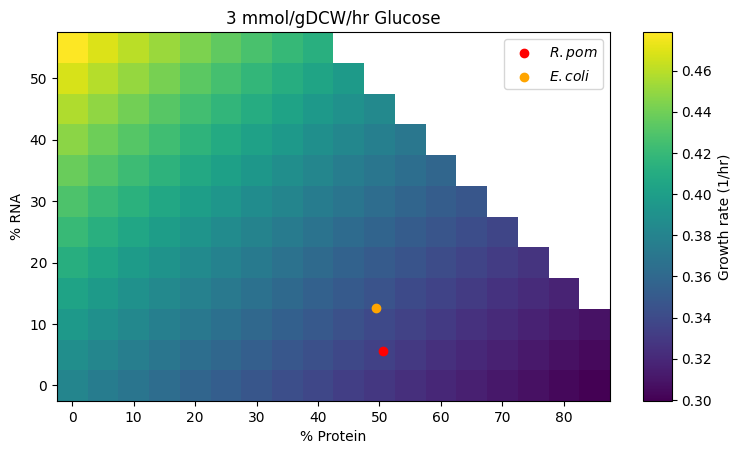

In [302]:
fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={"width_ratios" : [20,1]})
mappable = ax.imshow(growth, origin="lower")

step=2
ax.set_xticks(range(0, protein_prop.size, step), [f"{100 * p:.0f}" for p in protein_prop[::step]])
ax.set_yticks(range(0, rna_prop.size, step), [f"{100 * p:.0f}" for p in rna_prop[::step]])

ax.scatter(protein_prop.size * abs(biomass.metabolites[PROTEIN]),
           rna_prop.size * abs(biomass.metabolites[RNA]),
           color = "red",
           label="$R. pom$")

ax.scatter(protein_prop.size * .55,
           rna_prop.size * .21,
           color = "orange",
           label="$E. coli$")

ax.set_xlabel("% Protein")
ax.set_ylabel("% RNA")
ax.set_title("3 mmol/gDCW/hr Glucose")
ax.legend()

fig.colorbar(mappable, cax=cax, label="Growth rate (1/hr)")
fig.tight_layout()
fig.set_size_inches(8, 4)


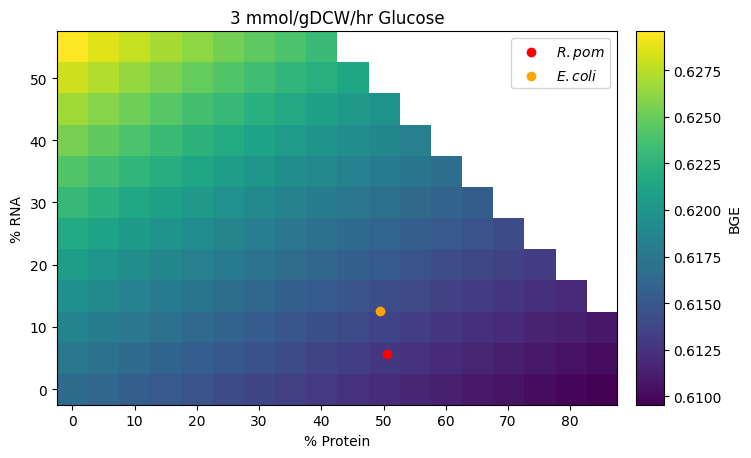

In [303]:
fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={"width_ratios" : [20,1]})
mappable = ax.imshow(bge, origin="lower")

step=2
ax.set_xticks(range(0, protein_prop.size, step), [f"{100 * p:.0f}" for p in protein_prop[::step]])
ax.set_yticks(range(0, rna_prop.size, step), [f"{100 * p:.0f}" for p in rna_prop[::step]])

ax.scatter(protein_prop.size * abs(biomass.metabolites[PROTEIN]),
           rna_prop.size * abs(biomass.metabolites[RNA]),
           color = "red",
           label="$R. pom$")

ax.scatter(protein_prop.size * .55,
           rna_prop.size * .21,
           color = "orange",
           label="$E. coli$")

ax.set_xlabel("% Protein")
ax.set_ylabel("% RNA")
ax.set_title("3 mmol/gDCW/hr Glucose")
ax.legend()

fig.colorbar(mappable, cax=cax, label="BGE")
# cax.set_yticks(np.arange(.61, .628, .005))

fig.tight_layout()
fig.set_size_inches(8, 4)


In [304]:
PROTEIN = model.metabolites.get_by_id("PROTEIN[c]")
RNA = model.metabolites.get_by_id("RNA[c]")

# Store original total - protein - RNA, for later scaling
# non_protein_total = abs(non_energy_total) - abs(biomass.metabolites[PROTEIN])
non_protein_or_rna_total = 1 - abs(biomass.metabolites[PROTEIN]) - abs(biomass.metabolites[RNA])

protein_prop = np.arange(0, 0.9, 0.05)
rna_prop = np.arange(0, 0.6, 0.05)

# protein_prop = np.arange(0.1, 0.9, 0.1)
# rna_prop = np.arange(0.1, 0.9, 0.1)
growth = np.zeros((rna_prop.size, protein_prop.size))
bge = np.zeros((rna_prop.size, protein_prop.size))

def task(params):
    r, c, p_protein, p_rna = params
    print(".oOX"[int(3 * (r*c) / (growth.size))], end="")
    
    # Skip if impossible
    if p_protein + p_rna >= 1:
        return (r, c, float("nan"), float("nan"))

    with model:
        # Constrain uptake
        ex_ace.bounds = (-15, 0)
        
        # Modify biomass objective:
        # 1) Set protein, rna coefficients to the above
        biomass.add_metabolites({PROTEIN : -p_protein}, combine=False)
        biomass.add_metabolites({RNA : -p_rna}, combine=False)

        # 2) Scale everything else to take up the remaining space
        remaining = 1 - abs(p_protein) - abs(p_rna)
        scale_factor = (remaining / non_protein_or_rna_total)
        for met in non_energy_biomass:
            if met.id in {PROTEIN.id, RNA.id}:
                continue

            biomass.add_metabolites(
                {met : biomass.metabolites[met] * scale_factor},
                combine=False
            )

        sol = model.optimize()
        
        c_ex_rxns = cue.get_c_ex_rxns(model)
        c_uptake, c_secret = cue.get_c_ex_rxn_fluxes(sol, c_ex_rxns, "cobrapy")
        bge_model = cue.calculate_cue(c_uptake, c_secret, "EX_co2")
        
        # p_other = 1 - abs(non_energy_total)
        # assert abs(
        #     abs(sum(biomass.metabolites[met] for met in non_energy_biomass) - p_other * scale_factor)
        #     - 1) <= 1e-6, f"{abs(sum(biomass.metabolites[met] for met in non_energy_biomass) - p_other * scale_factor)} != 1"
        
        return (r, c, sol.objective_value, bge_model)

params = [(r, c, p_protein, p_rna) for c, p_protein in enumerate(protein_prop) for r, p_rna in enumerate(rna_prop)]
with multiprocessing.Pool() as pool:
    results = pool.map(task, params)

for r, c, mu, bge_value in results:
    growth[r, c] = mu
    bge[r, c] = bge_value

...............................................................o.......o.......o.........o........................o..o.oo.....ooo....o...o...ooooo....o..o.oo.oooO.oo....oo..oOO...oo.o.oooOOO.ooooOOO..o......oooo.o..o

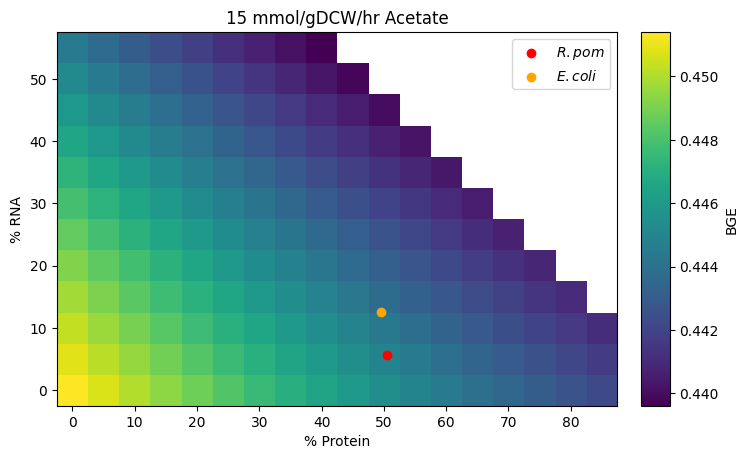

In [305]:
fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={"width_ratios" : [20,1]})
mappable = ax.imshow(bge, origin="lower")

step=2
ax.set_xticks(range(0, protein_prop.size, step), [f"{100 * p:.0f}" for p in protein_prop[::step]])
ax.set_yticks(range(0, rna_prop.size, step), [f"{100 * p:.0f}" for p in rna_prop[::step]])

ax.scatter(protein_prop.size * abs(biomass.metabolites[PROTEIN]),
           rna_prop.size * abs(biomass.metabolites[RNA]),
           color = "red",
           label="$R. pom$")

ax.scatter(protein_prop.size * .55,
           rna_prop.size * .21,
           color = "orange",
           label="$E. coli$")

ax.set_xlabel("% Protein")
ax.set_ylabel("% RNA")
ax.set_title("15 mmol/gDCW/hr Acetate")
ax.legend()

fig.colorbar(mappable, cax=cax, label="BGE")
# cax.set_yticks(np.arange(.61, .628, .005))

fig.tight_layout()
fig.set_size_inches(8, 4)


In [306]:
data = """carbon source	R/M	P/M	PHB/M
15 mM succinate	0.1091602756274100	0.468935809621904	
15 mM succinate	0.1091164064913170	0.543721356795469	
15 mM succinate			0.1584195281611030
10 mM glucose	0.0889823117881046	0.537437414850447	
10 mM glucose	0.0989713550063904	0.514529243689561	
10 mM glucose	0.0928398599927527	0.632599082513923	
10 mM glucose			0.0913728574406865"""

data = [[s.strip() if s.strip() != "" else "NaN" for s in line.split("\t") ] for line in data.split("\n")]

cols = data[0]
df = pd.DataFrame([dict(zip(cols, line)) for line in data[1:]])

df["R/M"] = df["R/M"].astype(float)
df["P/M"] = df["P/M"].astype(float)
df["PHB/M"] = df["PHB/M"].astype(float)

df

,carbon source,R/M,P/M,PHB/M
0,15 mM succinate,0.109160,0.468936,NaN
1,15 mM succinate,0.109116,0.543721,NaN
2,15 mM succinate,NaN,NaN,0.158420
3,10 mM glucose,0.088982,0.537437,NaN
4,10 mM glucose,0.098971,0.514529,NaN
5,10 mM glucose,0.092840,0.632599,NaN
6,10 mM glucose,NaN,NaN,0.091373


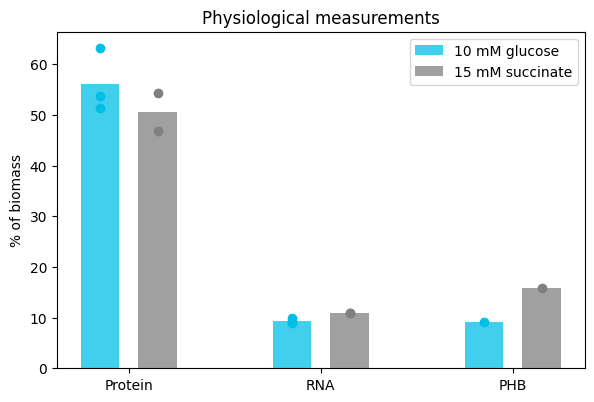

In [307]:
fig, ax = plt.subplots()

for x, component in enumerate(["P/M", "R/M", "PHB/M"]):
    for offset, c_source in zip([-.15, .15], ["10 mM glucose", "15 mM succinate"]):
        points = 100 * df[df["carbon source"] == c_source][component]
        color = (0, .75, .9) if c_source == "10 mM glucose" else "0.5"
        ax.bar(x + offset,
               points.mean(),
               width=0.2,
               color=color,
               alpha=0.75,
               label=c_source if x == 0 else None)
        ax.scatter([x + offset] * len(points), points, color=color, alpha=1)

ax.set_xticks(range(3), ["Protein", "RNA", "PHB"])
ax.set_ylabel("% of biomass")

ax.set_title("Physiological measurements")
ax.legend()

fig.tight_layout()
fig.set_size_inches(6, 4)

In [308]:
shadow_prices = []

for ex in [ex_ace, ex_glc]:
    with model:
        # Constrain uptake
        ex.bounds = (-15, 0)

        sol = model.optimize()
        
        c_ex_rxns = cue.get_c_ex_rxns(model)
        c_uptake, c_secret = cue.get_c_ex_rxn_fluxes(sol, c_ex_rxns, "cobrapy")
        bge_model = cue.calculate_cue(c_uptake, c_secret, "EX_co2")

        for precursor, coeff in biomass.metabolites.items():
            if coeff < 0:
                shadow_prices.append({
                    "carbon source" : ex.id,
                    "precursor" : precursor.id,
                    "shadow price" : sol.shadow_prices[precursor.id]
                })

shadow_prices = pd.DataFrame(shadow_prices)


In [309]:
shadow_prices[shadow_prices["carbon source"] == "EX_ac"].sort_values("shadow price")

,carbon source,precursor,shadow price
3,EX_ac,LIPID[c],-1.449092
0,EX_ac,PROTEIN[c],-0.981067
4,EX_ac,COFACTORS[c],-0.955579
7,EX_ac,PHB-STORAGE[c],-0.800223
11,EX_ac,NADP[c],-0.477507
10,EX_ac,NAD[c],-0.472061
1,EX_ac,DNA[c],-0.462689
2,EX_ac,RNA[c],-0.419474
8,EX_ac,ATP[c],-0.222867
6,EX_ac,MUREIN[c],-0.022130


In [310]:
shadow_prices[shadow_prices["carbon source"] == "EX_glc"].sort_values("shadow price")

,carbon source,precursor,shadow price
12,EX_glc,PROTEIN[c],-7.481502e-01
16,EX_glc,COFACTORS[c],-5.137887e-01
14,EX_glc,RNA[c],-3.388989e-01
13,EX_glc,DNA[c],-3.365090e-01
23,EX_glc,NADP[c],-3.355258e-01
22,EX_glc,NAD[c],-3.195483e-01
15,EX_glc,LIPID[c],-2.933922e-01
20,EX_glc,ATP[c],-2.077064e-01
18,EX_glc,MUREIN[c],-7.492171e-03
19,EX_glc,PHB-STORAGE[c],-1.991239e-13


Text(0.5, 0, 'Shadow price')

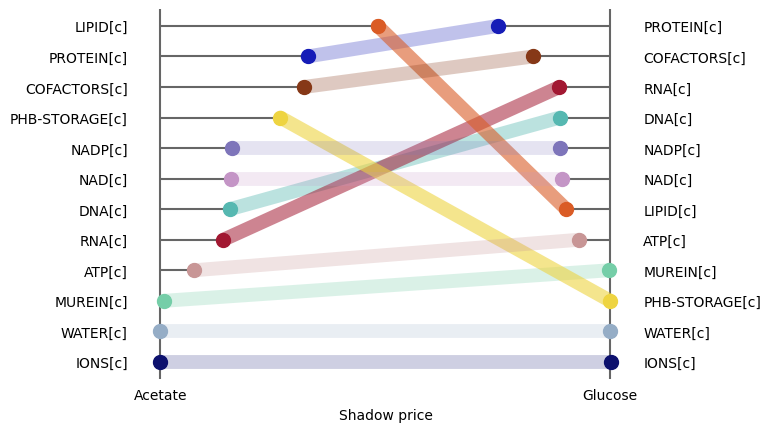

In [311]:
OFFSET = 3
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

colors = {'PROTEIN[c]': (22, 28, 183),
 'DNA[c]': (86, 184, 177),
 'RNA[c]': (162, 24, 50),
 'LIPID[c]': (218, 92, 38),
 'COFACTORS[c]': (134, 56, 23),
 'IONS[c]': (13, 17, 110),
 'MUREIN[c]': (117, 206, 168),
 'PHB-STORAGE[c]': (238, 212, 65),
 'ATP[c]': (200, 150, 150),
 'WATER[c]': (149, 173, 198),
 'NAD[c]': (196, 149, 198),
 'NADP[c]': (126, 117, 186)}
colors = {k: tuple(c / 255. for c in v) for k, v in colors.items()}

ax1.axvline(0, color="0.4", zorder=0, solid_capstyle="round")
ax1.axvline(OFFSET, color="0.4", zorder=0, solid_capstyle="round")

for substrate, ax in zip(["EX_ac", "EX_glc"], [ax1, ax2]):
    data = shadow_prices[shadow_prices["carbon source"] == substrate]
    data = data.sort_values("shadow price", ascending=False).reset_index(drop=True)

    for i, row in data.iterrows():
        precursor = row["precursor"]
        sp = row["shadow price"]

        ax.hlines(int(i),
                0 if substrate == "EX_ac" else OFFSET,
                -sp if substrate == "EX_ac" else (OFFSET + sp),
                color="0.4",
                zorder=0)
        ax.scatter(-sp if substrate == "EX_ac" else (OFFSET + sp),
                   int(i),
                   color=colors[precursor],
                   s=100)
    
    ax.set_yticks(range(data.shape[0]), [f"{row['precursor']}" for _, row in data.iterrows()])


data_ace = shadow_prices[(shadow_prices["carbon source"] == "EX_ac")]
data_ace = data_ace.sort_values("shadow price", ascending=False).reset_index(drop=True)
data_glc = shadow_prices[(shadow_prices["carbon source"] == "EX_glc")]
data_glc = data_glc.sort_values("shadow price", ascending=False).reset_index(drop=True)

for precursor in shadow_prices["precursor"].unique():
    x1 = - data_ace[data_ace["precursor"] == precursor]["shadow price"]
    x2 = OFFSET + data_glc[data_glc["precursor"] == precursor]["shadow price"]
    y1 = data_ace[data_ace["precursor"] == precursor].index
    y2 = data_glc[data_glc["precursor"] == precursor].index
    N = len(data_ace)

    ax1.plot(
        [x1, x2],
        [y1, y2],
        color=colors[precursor],
        label=precursor,
        # linestyle="--",
        linewidth=10,
        alpha=np.interp(abs(y1-y2), [0, N], [0.2, 1])[0],  # Larger changes = more solid (good default value is 0.3)
        zorder=0,
        solid_capstyle="round")

for ax in (ax1, ax2):
    ax.spines.left.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.tick_params(left=False, right=False, bottom=False)
ax1.set_xticks([0, OFFSET], ["Acetate", "Glucose"])
ax1.set_xlabel("Shadow price")

In [312]:
sugars = pd.read_csv("sugars.txt")
acids = pd.read_csv("organic acids.txt")

sugars["In model"] = sugars["Compounds"].apply(lambda x: f"{x}[c]" in model.metabolites)
acids["In model"] = acids["Compounds"].apply(lambda x: f"{x}[c]" in model.metabolites)

sugars = sugars[sugars["In model"]]
acids = acids[acids["In model"]]

print(f"{len(sugars)} sugars in model")
print(f"{len(acids)} acids in model")

46 sugars in model
213 acids in model


In [313]:
from cobra.core import Reaction
from utils.cobra_utils import get_or_create_exchange

biomass_precursors = [met.id for met, coeff in biomass.metabolites.items() if coeff < 0]

sugar_shadow_prices = []
for sugar in sugars["Compounds"]:
    with model:
        ex_glc.bounds = (0, 0)
        ex_ace.bounds = (0, 0)
        
        # Assume free transport - a fuller version would include transporters
        rxn = model.add_boundary(model.metabolites.get_by_id(f"{sugar}[c]"), type="sink", reaction_id=f"SK_{sugar.lower()}")
        rxn.bounds = (-10, 0)
        
        sol = model.optimize()
        sugar_shadow_prices.append({
            "compound" : sugar,
            "growth rate" : sol.objective_value,
            "shadow price" : sol.shadow_prices[biomass_precursors].values
        })

sugar_shadow_prices = pd.DataFrame(sugar_shadow_prices)
sugar_shadow_prices = sugar_shadow_prices[sugar_shadow_prices["growth rate"] > 0]
print(f"{len(sugar_shadow_prices)} sugars with positive growth rate")

21 sugars with positive growth rate


In [314]:
acid_shadow_prices = []
for acid in acids["Compounds"]:
    with model:
        ex_glc.bounds = (0, 0)
        ex_ace.bounds = (0, 0)
        
        # Assume free transport - a fuller version would include transporters
        rxn = model.add_boundary(model.metabolites.get_by_id(f"{acid}[c]"), type="sink", reaction_id=f"SK_{acid.lower()}")
        rxn.bounds = (-10, 0)
        
        sol = model.optimize()
        acid_shadow_prices.append({
            "compound" : acid,
            "growth rate" : sol.objective_value,
            "shadow price" : sol.shadow_prices[biomass_precursors].values
        })

acid_shadow_prices = pd.DataFrame(acid_shadow_prices)
acid_shadow_prices = acid_shadow_prices[acid_shadow_prices["growth rate"] > 0]
print(f"{len(acid_shadow_prices)} acids with positive growth rate")

93 acids with positive growth rate


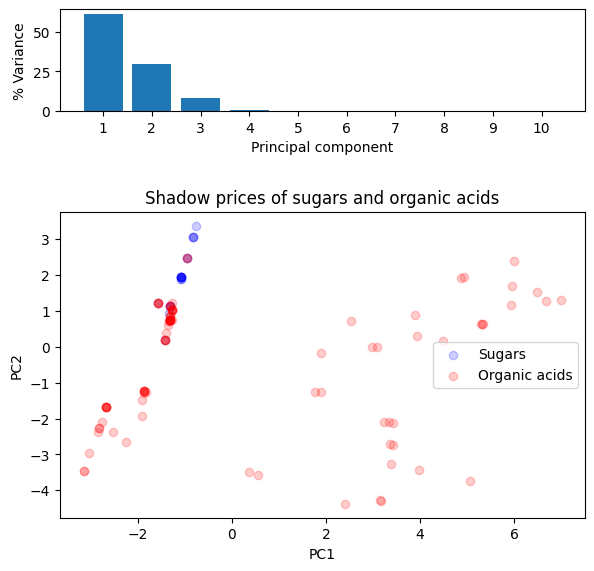

In [315]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data = pd.concat([sugar_shadow_prices, acid_shadow_prices],
                 keys=("sugar", "acid")).reset_index(0, names=["class"])

X = np.stack(data['shadow price'].values)
X = StandardScaler().fit_transform(X)

pca = PCA(n_components=10)
components = pca.fit_transform(X)

data["PC1"] = components[:, 0]
data["PC2"] = components[:, 1]

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={"height_ratios" : [1, 3]})

ax1.bar(np.arange(10), 100 * pca.explained_variance_ratio_)
ax1.set_xlabel("Principal component")
ax1.set_ylabel("% Variance")
ax1.set_xticks(range(10), range(1, 11))


labeled_sugars = False
labeled_acids = False
for i, row in data.iterrows():
    label = None
    if row["class"] == "sugar":
        if not labeled_sugars:
            label="Sugars"
            labeled_sugars = True
    if row["class"] == "acid":
        if not labeled_acids:
            label="Organic acids"
            labeled_acids = True

    ax2.scatter(row["PC1"],
               row["PC2"],
               color=("b" if row["class"] == "sugar" else "r"),
               alpha=0.2,
               label=label)

ax2.legend()

ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_title("Shadow prices of sugars and organic acids")

fig.tight_layout()
fig.set_size_inches(6, 6)

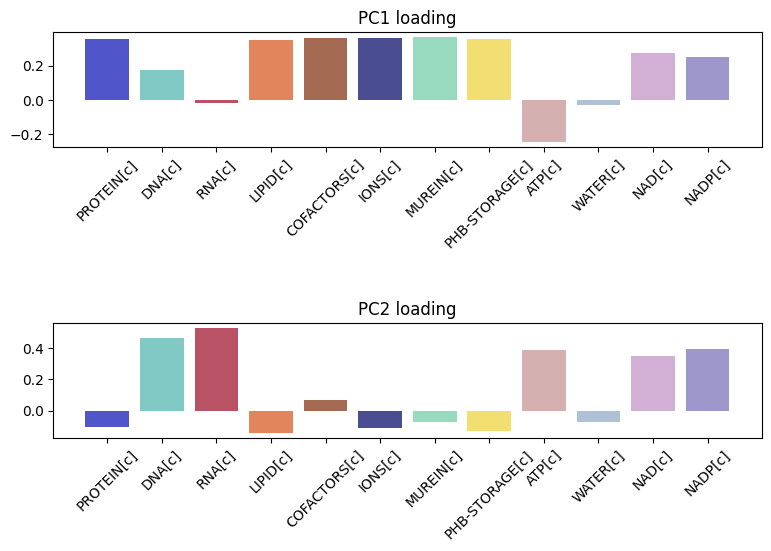

In [316]:
fig, axs = plt.subplots(2, 1)

for i, row in pd.DataFrame(pca.components_[:2], columns=biomass_precursors).iterrows():
    for precursor, val in zip(biomass_precursors, row):
        axs[i].bar(precursor, val, alpha=0.75, color=colors[precursor])
    axs[i].set_title(f"PC{i + 1} loading")
    axs[i].tick_params(axis="x", rotation=45)

fig.tight_layout()
fig.set_size_inches(8, 6)

In [317]:
precursor

'NADP[c]'